In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import time,datetime
import pywt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import fft,ifft,stats

# 基本预处理

In [2]:
df = pd.read_csv('./g-research-crypto-forecasting/train.csv',encoding = 'utf-8')

In [3]:
asset_0 = df[df['Asset_ID'] == 0]

In [5]:
asset_0 = asset_0.fillna(axis = 0,method = 'pad')

In [6]:
timestamp = list(asset_0['timestamp'])
asset_0['date'] = list(map(lambda x: time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(x)),timestamp))

In [7]:
asset_0.drop('timestamp',axis = 1, inplace = True)
asset_0 = asset_0.set_index('date')

In [8]:
asset_0

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
date,,,,,,,,,
2018-01-01 08:01:00,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2018-01-01 08:02:00,0,7.0,8.5300,8.5300,8.5145,8.5145,71.390000,8.520215,-0.015875
2018-01-01 08:03:00,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.820000,8.501394,-0.015410
2018-01-01 08:04:00,0,14.0,8.5009,8.5066,8.4744,8.5009,125.800000,8.479810,-0.012524
2018-01-01 08:05:00,0,5.0,8.5007,8.5007,8.4560,8.4560,125.010000,8.458435,-0.005940
...,...,...,...,...,...,...,...,...,...
2021-09-21 07:56:00,0,277.0,364.1115,364.2000,362.7000,362.9180,773.176000,363.458767,0.008493
2021-09-21 07:57:00,0,296.0,362.9265,363.2000,362.1000,362.2000,596.347783,362.655647,0.008493
2021-09-21 07:58:00,0,319.0,362.2310,362.4000,361.7000,361.8580,820.909736,361.962990,0.008493


In [14]:
x = asset_0.index
ticker_spacing = x
ticker_spacing = 100000


In [15]:
asset_2021 = asset_0['2021-01-01 00:00:00':'2021-09-21 08:00:00']

In [16]:
x = asset_2021.index

In [17]:
x = asset_2021.index
ticker_spacing = x
ticker_spacing = 100000


In [28]:
idx = np.linspace(0,len(asset_2021.index)-1,5).astype(int)
X = np.array(range(len(asset_2021))).reshape(-1,1) / len(asset_2021)
pf = PolynomialFeatures(85)
X = pf.fit_transform(X)
y = asset_2021['Close']
reg = LinearRegression().fit(X, y)
reg.score(X, y)


0.962218960585794

In [29]:
x = asset_2021.index

In [30]:
signal = reg.predict(X)-y
signal = signal-signal.mean()
fft_signal = np.abs(np.fft.fft(signal))
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]

In [31]:
len(asset_2021)

379054

In [32]:
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]

In [33]:
def filter_signal(th):
    f_s = fft_filter(th)
    return np.real(np.fft.ifft(f_s))
def fft_filter(perc):
    fft_signal = np.fft.fft(signal)
    fft_abs = np.abs(fft_signal)
    th=perc*(2*fft_abs[0:int(len(signal)/2.)]/len(asset_2021)).max()
    fft_tof=fft_signal.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(asset_2021)
    fft_tof[fft_tof_abs<=th]=0
    return fft_tof
def fft_filter_amp(th):
    fft = np.fft.fft(signal)
    fft_tof=fft.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(asset_2021)
    fft_tof_abs[fft_tof_abs<=th]=0
    return fft_tof_abs[0:int(len(fft_tof_abs)/2.)]

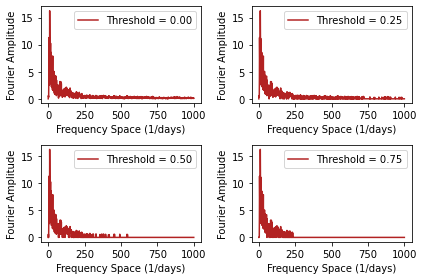

In [18]:
for i in range(0,4):
    plt.subplot(2,2,i+1)
    th_i=th_list[i].round(2)
    th_filter = fft_filter_amp(th_i)
    plt.plot(th_filter[0:1000],color='firebrick',label='Threshold = %.2f'%(th_list[i]))
    plt.xlabel('Frequency Space (1/days)')
    plt.ylabel('Fourier Amplitude')
    plt.legend()
plt.tight_layout()

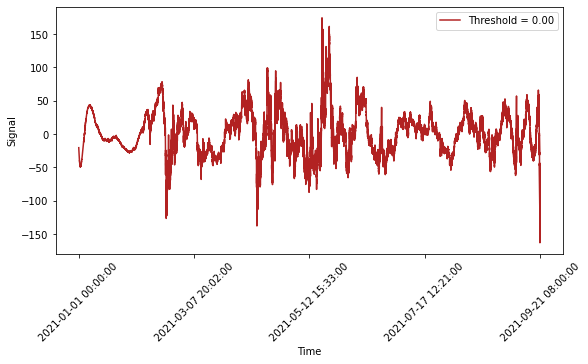

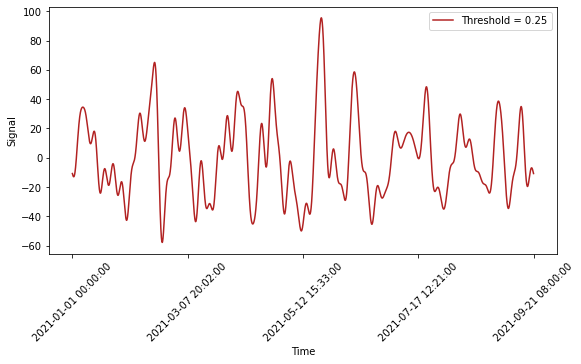

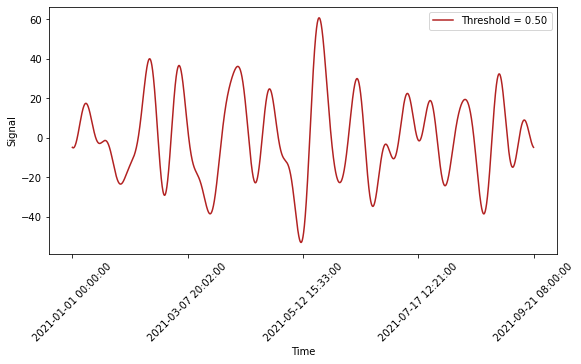

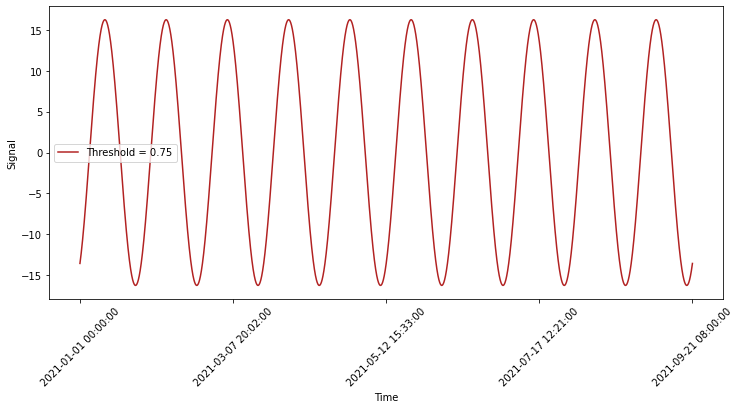

In [19]:
for i in range(0,4):
    plt.figure(figsize = (20,10))
    plt.subplot(2,2,i+1)
    th_i=th_list[i].round(2)
    th_filter = fft_filter(th_i)
    signal_filter =np.real(np.fft.ifft(th_filter))
    plt.plot(x,signal_filter,color='firebrick',label='Threshold = %.2f'%(th_list[i]))
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.xticks(x[idx],x[idx],rotation=45)
    plt.legend()
plt.tight_layout()

In [135]:
th_example_value = 0.25
example_signal = filter_signal(th_example_value)


In [34]:
def get_diff(i):
    plt.figure(figsize = (20,10))
    th_example_value = i
    example_signal = filter_signal(th_example_value)

    return example_signal

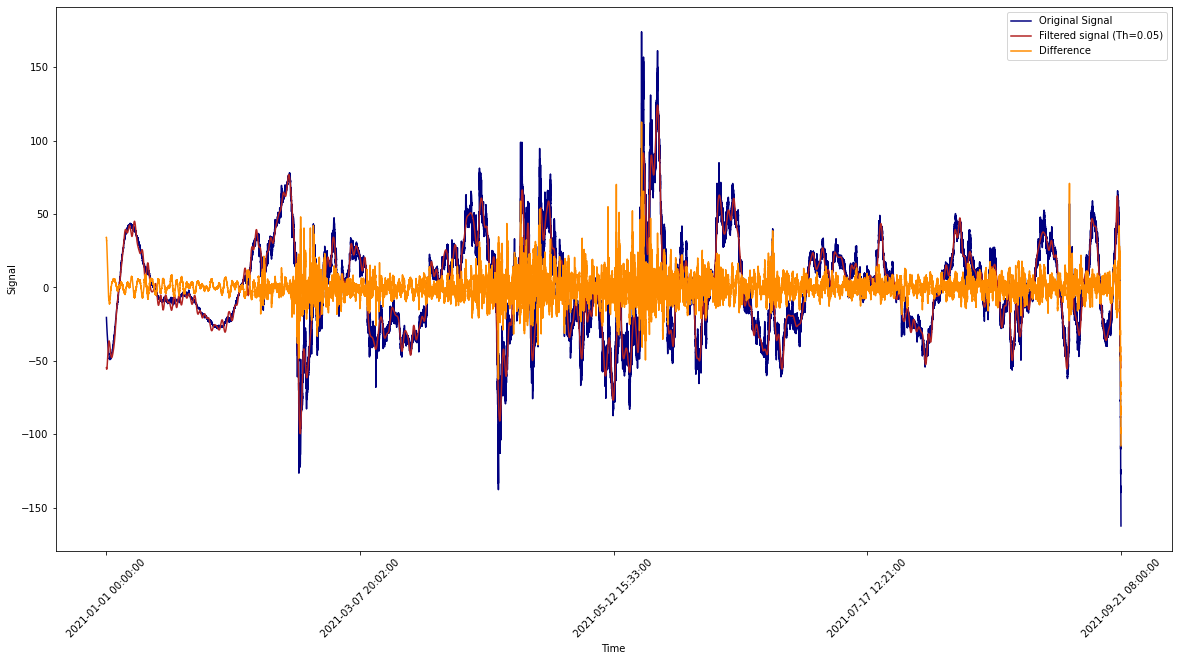

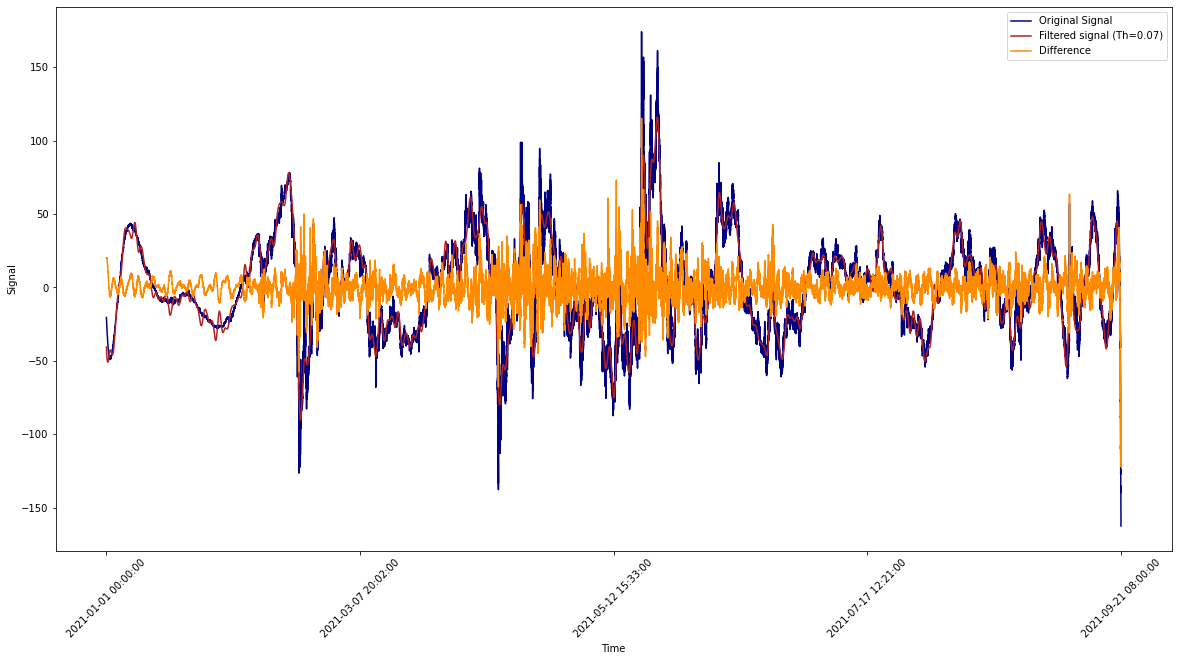

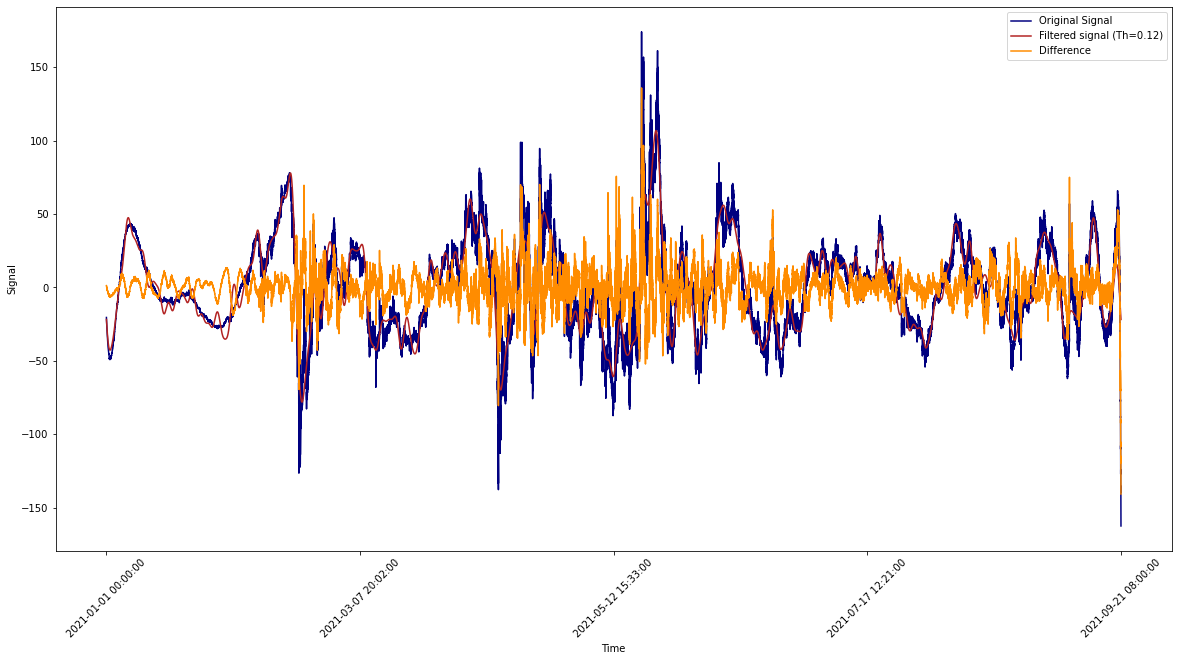

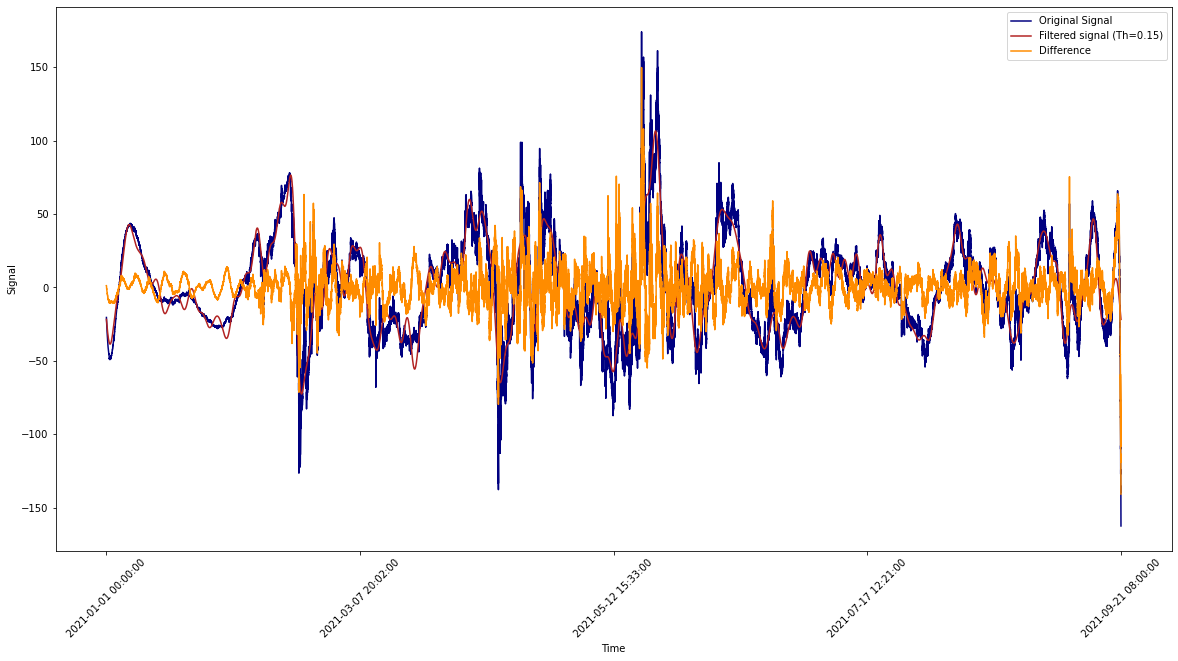

In [22]:
get_diff(0.05)
get_diff(0.075)
get_diff(0.125)

In [35]:
diff_2021 = get_diff(0.15)

<Figure size 1440x720 with 0 Axes>

In [36]:
res_2021 = reg.predict(X) - diff_2021
asset_2021['new_close'] = res_2021
asset_2021

<ipython-input-36-83518d993f74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2021['new_close'] = res_2021


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close
date,,,,,,,,,,,
2021-01-01 00:00:00,0,1396.0,37.06555,37.1000,36.5157,36.98655,17214.702300,36.927380,-0.002058,38.087345,37.966651
2021-01-01 00:01:00,0,225.0,36.94950,36.9966,36.9398,36.96135,2241.364000,36.956931,-0.002128,38.064792,37.944110
2021-01-01 00:02:00,0,188.0,36.98980,36.9977,36.9622,36.96230,1820.636000,36.982246,-0.000362,38.042311,37.921640
2021-01-01 00:03:00,0,116.0,36.97380,36.9870,36.9563,36.97210,532.294000,36.969818,-0.002141,38.019840,37.899180
2021-01-01 00:04:00,0,167.0,36.97230,37.0314,36.9568,37.01480,747.031000,36.989654,-0.001101,37.997424,37.876776
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-21 07:56:00,0,277.0,364.11150,364.2000,362.7000,362.91800,773.176000,363.458767,0.008493,223.410994,225.304312
2021-09-21 07:57:00,0,296.0,362.92650,363.2000,362.1000,362.20000,596.347783,362.655647,0.008493,223.932276,226.075606
2021-09-21 07:58:00,0,319.0,362.23100,362.4000,361.7000,361.85800,820.909736,361.962990,0.008493,222.578553,223.721894


In [26]:
idx = np.linspace(0,len(asset_2021.index)-1,5).astype(int)
X = np.array(range(len(asset_2021))).reshape(-1,1) / len(asset_2021)
pf = PolynomialFeatures(85)
X = pf.fit_transform(X)
y = asset_2021['Open']
reg = LinearRegression().fit(X, y)
reg.score(X, y)
signal = reg.predict(X)-y
signal = signal-signal.mean()
fft_signal = np.abs(np.fft.fft(signal))
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]
th_example_value = 0.15
example_signal = filter_signal(th_example_value)
open_2021 = reg.predict(X) - example_signal
asset_2021['new_open'] = open_2021
asset_2021

<ipython-input-26-5afbeef20ea5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2021['new_open'] = open_2021


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open
date,,,,,,,,,,
2021-01-01 00:00:00,0,1396.0,37.06555,37.1000,36.5157,36.98655,17214.702300,36.927380,-0.002058,38.087345
2021-01-01 00:01:00,0,225.0,36.94950,36.9966,36.9398,36.96135,2241.364000,36.956931,-0.002128,38.064792
2021-01-01 00:02:00,0,188.0,36.98980,36.9977,36.9622,36.96230,1820.636000,36.982246,-0.000362,38.042311
2021-01-01 00:03:00,0,116.0,36.97380,36.9870,36.9563,36.97210,532.294000,36.969818,-0.002141,38.019840
2021-01-01 00:04:00,0,167.0,36.97230,37.0314,36.9568,37.01480,747.031000,36.989654,-0.001101,37.997424
...,...,...,...,...,...,...,...,...,...,...
2021-09-21 07:56:00,0,277.0,364.11150,364.2000,362.7000,362.91800,773.176000,363.458767,0.008493,223.410994
2021-09-21 07:57:00,0,296.0,362.92650,363.2000,362.1000,362.20000,596.347783,362.655647,0.008493,223.932276
2021-09-21 07:58:00,0,319.0,362.23100,362.4000,361.7000,361.85800,820.909736,361.962990,0.008493,222.578553


In [236]:
signal = reg.predict(X)-y
signal = signal-signal.mean()
fft_signal = np.abs(np.fft.fft(signal))
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]
th_example_value = 0.15
example_signal = filter_signal(th_example_value)
open_2021 = reg.predict(X) - example_signal
asset_2021['new_open'] = open_2021
asset_2021

<ipython-input-236-f38d2a0d891f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2021['new_open'] = open_2021


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close
date,,,,,,,,,,,
2021-01-01 00:00:00,0,1396.0,37.06555,37.1000,36.5157,36.98655,17214.702300,36.927380,-0.002058,23.848769,37.966651
2021-01-01 00:01:00,0,225.0,36.94950,36.9966,36.9398,36.96135,2241.364000,36.956931,-0.002128,23.795676,37.944110
2021-01-01 00:02:00,0,188.0,36.98980,36.9977,36.9622,36.96230,1820.636000,36.982246,-0.000362,23.742675,37.921640
2021-01-01 00:03:00,0,116.0,36.97380,36.9870,36.9563,36.97210,532.294000,36.969818,-0.002141,23.689734,37.899180
2021-01-01 00:04:00,0,167.0,36.97230,37.0314,36.9568,37.01480,747.031000,36.989654,-0.001101,23.636855,37.876776
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-21 07:56:00,0,277.0,364.11150,364.2000,362.7000,362.91800,773.176000,363.458767,0.008493,587.359954,225.304312
2021-09-21 07:57:00,0,296.0,362.92650,363.2000,362.1000,362.20000,596.347783,362.655647,0.008493,590.362695,226.075606
2021-09-21 07:58:00,0,319.0,362.23100,362.4000,361.7000,361.85800,820.909736,361.962990,0.008493,585.365451,223.721894


In [240]:
th_example_value = 0.25
example_signal = filter_signal(th_example_value)
open_2021 = reg.predict(X) - example_signal
asset_2021['new_open'] = open_2021
asset_2021

<ipython-input-240-ae0f8f4209dc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2021['new_open'] = open_2021


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close
date,,,,,,,,,,,
2021-01-01 00:00:00,0,1396.0,37.06555,37.1000,36.5157,36.98655,17214.702300,36.927380,-0.002058,37.918136,37.966651
2021-01-01 00:01:00,0,225.0,36.94950,36.9966,36.9398,36.96135,2241.364000,36.956931,-0.002128,37.860580,37.944110
2021-01-01 00:02:00,0,188.0,36.98980,36.9977,36.9622,36.96230,1820.636000,36.982246,-0.000362,37.803095,37.921640
2021-01-01 00:03:00,0,116.0,36.97380,36.9870,36.9563,36.97210,532.294000,36.969818,-0.002141,37.745650,37.899180
2021-01-01 00:04:00,0,167.0,36.97230,37.0314,36.9568,37.01480,747.031000,36.989654,-0.001101,37.688246,37.876776
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-21 07:56:00,0,277.0,364.11150,364.2000,362.7000,362.91800,773.176000,363.458767,0.008493,601.451330,225.304312
2021-09-21 07:57:00,0,296.0,362.92650,363.2000,362.1000,362.20000,596.347783,362.655647,0.008493,604.449710,226.075606
2021-09-21 07:58:00,0,319.0,362.23100,362.4000,361.7000,361.85800,820.909736,361.962990,0.008493,599.448085,223.721894


In [37]:
idx = np.linspace(0,len(asset_2021.index)-1,5).astype(int)
X = np.array(range(len(asset_2021))).reshape(-1,1) / len(asset_2021)
pf = PolynomialFeatures(100)
X = pf.fit_transform(X)
y = asset_2021['High']
reg = LinearRegression().fit(X, y)
reg.score(X, y)
signal = reg.predict(X)-y
signal = signal-signal.mean()
fft_signal = np.abs(np.fft.fft(signal))
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]
th_example_value = 0.075
example_signal = filter_signal(th_example_value)
open_2021 = reg.predict(X) - example_signal
asset_2021['new_high'] = open_2021
asset_2021

<ipython-input-37-b0f9f81f7864>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2021['new_high'] = open_2021


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close,new_high
date,,,,,,,,,,,,
2021-01-01 00:00:00,0,1396.0,37.06555,37.1000,36.5157,36.98655,17214.702300,36.927380,-0.002058,38.087345,37.966651,54.363984
2021-01-01 00:01:00,0,225.0,36.94950,36.9966,36.9398,36.96135,2241.364000,36.956931,-0.002128,38.064792,37.944110,54.361395
2021-01-01 00:02:00,0,188.0,36.98980,36.9977,36.9622,36.96230,1820.636000,36.982246,-0.000362,38.042311,37.921640,54.358747
2021-01-01 00:03:00,0,116.0,36.97380,36.9870,36.9563,36.97210,532.294000,36.969818,-0.002141,38.019840,37.899180,54.356057
2021-01-01 00:04:00,0,167.0,36.97230,37.0314,36.9568,37.01480,747.031000,36.989654,-0.001101,37.997424,37.876776,54.353308
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-21 07:56:00,0,277.0,364.11150,364.2000,362.7000,362.91800,773.176000,363.458767,0.008493,223.410994,225.304312,238.180712
2021-09-21 07:57:00,0,296.0,362.92650,363.2000,362.1000,362.20000,596.347783,362.655647,0.008493,223.932276,226.075606,239.493218
2021-09-21 07:58:00,0,319.0,362.23100,362.4000,361.7000,361.85800,820.909736,361.962990,0.008493,222.578553,223.721894,239.268038


In [38]:
idx = np.linspace(0,len(asset_2021.index)-1,5).astype(int)
X = np.array(range(len(asset_2021))).reshape(-1,1) / len(asset_2021)
pf = PolynomialFeatures(100)
X = pf.fit_transform(X)
y = asset_2021['Low']
reg = LinearRegression().fit(X, y)
reg.score(X, y)
signal = reg.predict(X)-y
signal = signal-signal.mean()
fft_signal = np.abs(np.fft.fft(signal))
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]
th_example_value = 0.1
example_signal = filter_signal(th_example_value)
open_2021 = reg.predict(X) - example_signal
asset_2021['new_low'] = open_2021
asset_2021

<ipython-input-38-dde3d3f1036e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2021['new_low'] = open_2021


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close,new_high,new_low
date,,,,,,,,,,,,,
2021-01-01 00:00:00,0,1396.0,37.06555,37.1000,36.5157,36.98655,17214.702300,36.927380,-0.002058,38.087345,37.966651,54.363984,43.405082
2021-01-01 00:01:00,0,225.0,36.94950,36.9966,36.9398,36.96135,2241.364000,36.956931,-0.002128,38.064792,37.944110,54.361395,43.396709
2021-01-01 00:02:00,0,188.0,36.98980,36.9977,36.9622,36.96230,1820.636000,36.982246,-0.000362,38.042311,37.921640,54.358747,43.388313
2021-01-01 00:03:00,0,116.0,36.97380,36.9870,36.9563,36.97210,532.294000,36.969818,-0.002141,38.019840,37.899180,54.356057,43.379940
2021-01-01 00:04:00,0,167.0,36.97230,37.0314,36.9568,37.01480,747.031000,36.989654,-0.001101,37.997424,37.876776,54.353308,43.371545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-21 07:56:00,0,277.0,364.11150,364.2000,362.7000,362.91800,773.176000,363.458767,0.008493,223.410994,225.304312,238.180712,226.703110
2021-09-21 07:57:00,0,296.0,362.92650,363.2000,362.1000,362.20000,596.347783,362.655647,0.008493,223.932276,226.075606,239.493218,227.467081
2021-09-21 07:58:00,0,319.0,362.23100,362.4000,361.7000,361.85800,820.909736,361.962990,0.008493,222.578553,223.721894,239.268038,224.878003


In [68]:

asset_2021

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close
date,,,,,,,,,,,
2021-01-01 00:00:00,0,1396.0,37.06555,37.1000,36.5157,36.98655,17214.702300,36.927380,-0.002058,38.087345,37.966651
2021-01-01 00:01:00,0,225.0,36.94950,36.9966,36.9398,36.96135,2241.364000,36.956931,-0.002128,38.064792,37.944110
2021-01-01 00:02:00,0,188.0,36.98980,36.9977,36.9622,36.96230,1820.636000,36.982246,-0.000362,38.042311,37.921640
2021-01-01 00:03:00,0,116.0,36.97380,36.9870,36.9563,36.97210,532.294000,36.969818,-0.002141,38.019840,37.899180
2021-01-01 00:04:00,0,167.0,36.97230,37.0314,36.9568,37.01480,747.031000,36.989654,-0.001101,37.997424,37.876776
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-21 07:56:00,0,277.0,364.11150,364.2000,362.7000,362.91800,773.176000,363.458767,0.008493,223.410994,225.304312
2021-09-21 07:57:00,0,296.0,362.92650,363.2000,362.1000,362.20000,596.347783,362.655647,0.008493,223.932276,226.075606
2021-09-21 07:58:00,0,319.0,362.23100,362.4000,361.7000,361.85800,820.909736,361.962990,0.008493,222.578553,223.721894


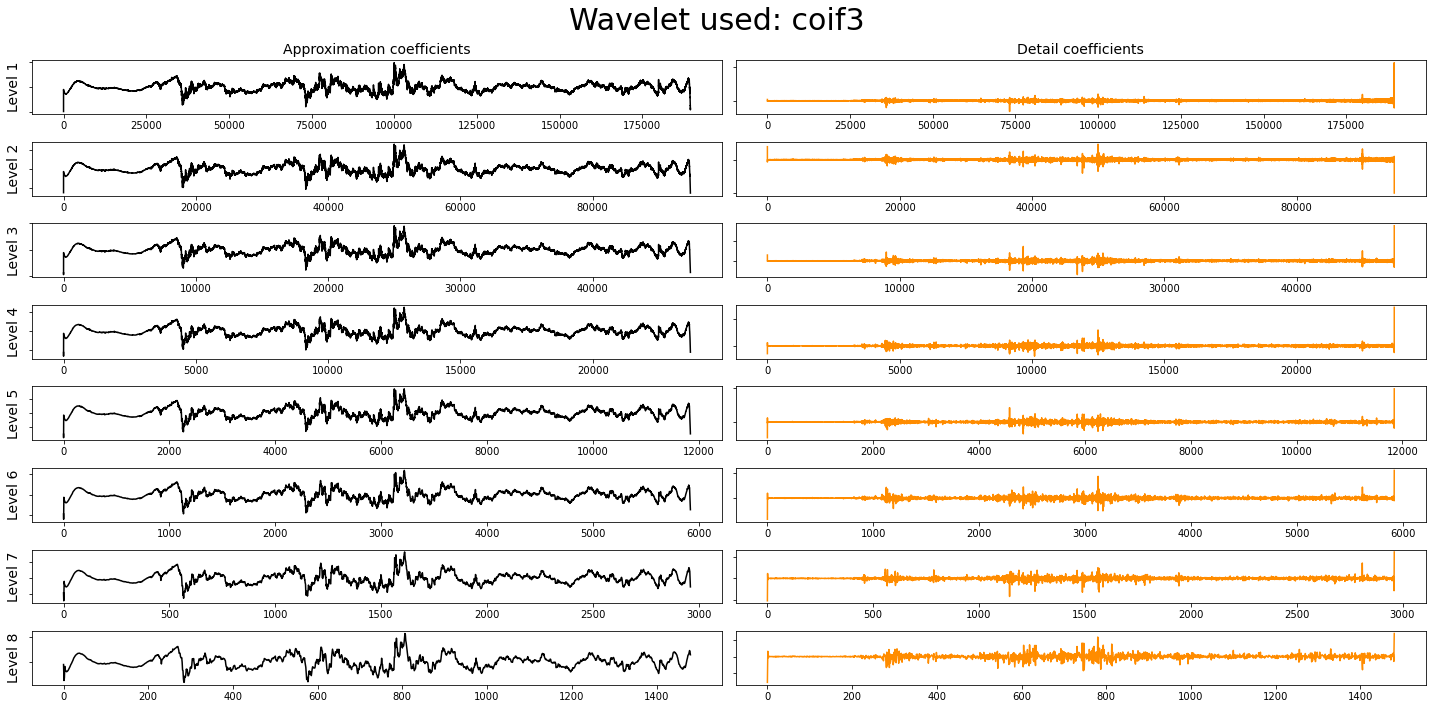

In [36]:
dataset = signal
waveletname = 'coif3'
levels=8
fig, axarr = plt.subplots(nrows=levels, ncols=2, figsize=(20,10))
COEFF_D=[]
DATASET=[]
k=1
plt.suptitle('Wavelet used: %s'%(waveletname),fontsize=30)
for ii in range(levels):
    (dataset, coeff_d) = pywt.dwt(dataset, waveletname,mode='per')
    axarr[ii, 0].plot(dataset, 'black')
    axarr[ii, 1].plot(coeff_d, 'darkorange')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
    #print(len(coeff_d))
    COEFF_D.append(np.repeat(coeff_d,2**k))
    DATASET.append(np.repeat(dataset,2**k))
    k=k+1
plt.tight_layout()
plt.show()

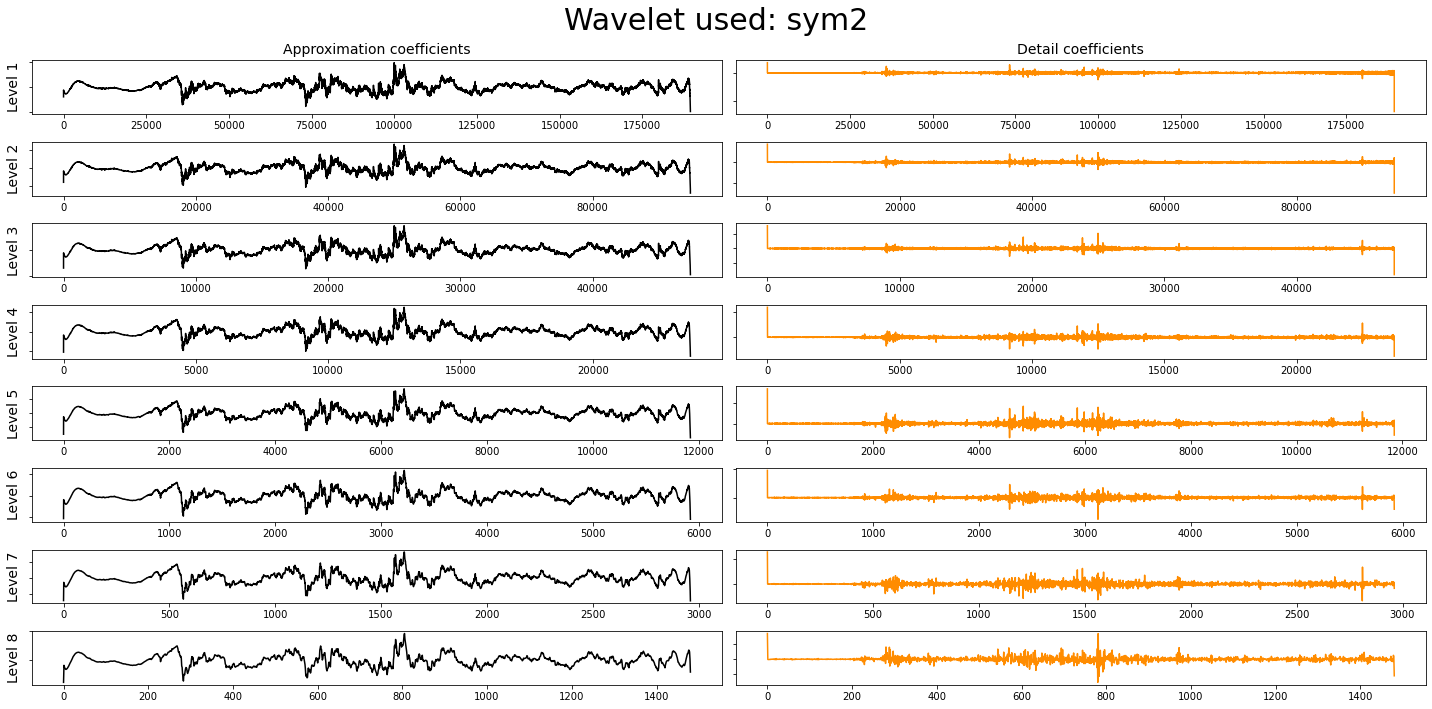

In [37]:
dataset = signal
waveletname = 'sym2'
levels=8
fig, axarr = plt.subplots(nrows=levels, ncols=2, figsize=(20,10))
COEFF_D=[]
DATASET=[]
k=1
plt.suptitle('Wavelet used: %s'%(waveletname),fontsize=30)
for ii in range(levels):
    (dataset, coeff_d) = pywt.dwt(dataset, waveletname,mode='per')
    axarr[ii, 0].plot(dataset, 'black')
    axarr[ii, 1].plot(coeff_d, 'darkorange')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
    #print(len(coeff_d))
    COEFF_D.append(np.repeat(coeff_d,2**k))
    DATASET.append(np.repeat(dataset,2**k))
    k=k+1
plt.tight_layout()
plt.show()

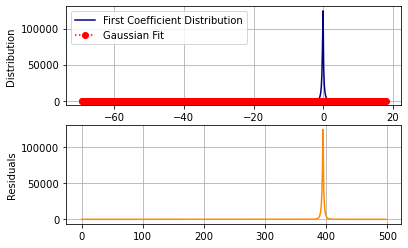

In [38]:
def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
x=np.histogram(COEFF_D[0],500)[1][0:500]
y=np.histogram(COEFF_D[0],500)[0]
def takeClosest(num,collection):
    collection=collection.tolist()
    collection=np.array(collection)
    if num>=0:
        collection=np.abs(collection[np.where(collection>0)])
        a= min(collection,key=lambda x:abs(x-abs(num)))
    else:
        collection=np.abs(collection[np.where(collection<0)])

        a= -min(collection,key=lambda x:abs(x-abs(num)))
    return a
x_try=x
b=x.tolist().index(takeClosest(500,x))
a=x.tolist().index(takeClosest(-500,x))
x=x[a:b]
y=y[a:b]


val_medio=x[int(len(x)/2)]
n = len(x)                       #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-val_medio)**2)/n        #note this correction
p0 = [max(y),val_medio,10]
popt,pcov = curve_fit(gaus,x,y,p0=p0)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_ylabel('Distribution ')
ax1.plot(x,y,'navy',label='First Coefficient Distribution')
ax1.grid(True)
plt.ylabel('Residuals')
ax1.plot(x,gaus(x,*popt),'ro:',label='Gaussian Fit')
ax1.legend()
res = y - gaus(x,*popt)
ax2.plot(res,color='darkorange')
ax2.grid(True)
plt.show()

D:\Anaconda\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


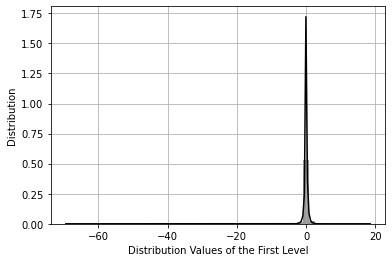

In [39]:
y=sns.distplot(COEFF_D[0],color='k').get_lines()[0].get_data()[1][a:b]
plt.ylabel('Distribution')
plt.xlabel('Distribution Values of the First Level')
plt.grid(True)

In [40]:
TH = np.arange(0.0,100,0.1)
C_TH=[]
for t in TH:
    rec=recons_from_th_zero(t)
    rec = rec[1::]
    C_TH.append(np.abs(np.corrcoef(rec-test,test)[0][1]))

plt.plot(TH[0:150],C_TH[0:150])
plt.xlabel('$\Theta$')
plt.ylabel('Difference-Signal Correlation')

NameError: name 'recons_from_th_zero' is not defined

In [39]:
asset_2018 = asset_0['2018-01-01 08:01:00':'2018-12-31 23:59:00']
asset_2019 = asset_0['2019-01-01 00:00:00':'2019-12-31 23:59:00']
asset_2020 = asset_0['2020-01-01 00:00:00':'2020-12-31 23:59:00']

In [40]:
asset_2018

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
date,,,,,,,,,
2018-01-01 08:01:00,0,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399
2018-01-01 08:02:00,0,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875
2018-01-01 08:03:00,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410
2018-01-01 08:04:00,0,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524
2018-01-01 08:05:00,0,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940
...,...,...,...,...,...,...,...,...,...
2018-12-31 23:54:00,0,11.0,6.0503,6.0503,6.0484,6.0484,2786.29,6.050080,0.004840
2018-12-31 23:55:00,0,6.0,6.0483,6.0540,6.0483,6.0540,194.70,6.048401,0.005534
2018-12-31 23:56:00,0,1.0,6.0540,6.0540,6.0540,6.0540,4.23,6.054000,0.005583


In [41]:
asset_2019

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
date,,,,,,,,,
2019-01-01 00:00:00,0,51.0,6.0583,6.0970,6.0577,6.0964,3580.03,6.078219,0.000000
2019-01-01 00:01:00,0,55.0,6.0991,6.0991,6.0676,6.0721,3793.28,6.077251,0.000577
2019-01-01 00:02:00,0,92.0,6.0671,6.0756,6.0485,6.0694,5915.57,6.058061,0.000379
2019-01-01 00:03:00,0,8.0,6.0724,6.0782,6.0676,6.0704,1432.29,6.070275,-0.000115
2019-01-01 00:04:00,0,7.0,6.0781,6.0783,6.0726,6.0783,310.81,6.077122,-0.000757
...,...,...,...,...,...,...,...,...,...
2019-12-31 23:55:00,0,79.0,13.7856,13.7856,13.7684,13.7744,1601.01,13.770815,0.000875
2019-12-31 23:56:00,0,63.0,13.7659,13.7733,13.7606,13.7650,575.40,13.766628,0.001905
2019-12-31 23:57:00,0,39.0,13.7650,13.7650,13.7507,13.7509,1069.89,13.755258,0.001644


In [42]:
x = asset_2018.index
ticker_spacing = x
ticker_spacing = 100000


In [45]:
idx = np.linspace(0,len(asset_2018.index)-1,5).astype(int)
X = np.array(range(len(asset_2018))).reshape(-1,1) / len(asset_2018)
pf = PolynomialFeatures(50)
X = pf.fit_transform(X)
y = asset_2018['Close']
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.9075962150427724

In [46]:
x = asset_2018.index


In [47]:
signal = reg.predict(X)-y
signal = signal-signal.mean()
fft_signal = np.abs(np.fft.fft(signal))


In [48]:
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]

In [49]:
th_example_value = 0.15
example_signal = filter_signal(th_example_value)


In [50]:
res_2018 = reg.predict(X) - example_signal
asset_2018['new_close'] = res_2018
asset_2018

<ipython-input-50-c3eadafdc8bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2018['new_close'] = res_2018


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close
date,,,,,,,,,,,
2018-01-01 08:01:00,0,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399,7.496533,7.490614
2018-01-01 08:02:00,0,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875,7.496714,7.490805
2018-01-01 08:03:00,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410,7.496896,7.490997
2018-01-01 08:04:00,0,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524,7.497078,7.491189
2018-01-01 08:05:00,0,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940,7.497262,7.491383
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:54:00,0,11.0,6.0503,6.0503,6.0484,6.0484,2786.29,6.050080,0.004840,8.050738,8.094873
2018-12-31 23:55:00,0,6.0,6.0483,6.0540,6.0483,6.0540,194.70,6.048401,0.005534,8.113611,8.110878
2018-12-31 23:56:00,0,1.0,6.0540,6.0540,6.0540,6.0540,4.23,6.054000,0.005583,8.090545,7.978446


In [44]:
idx = np.linspace(0,len(asset_2018.index)-1,5).astype(int)
X = np.array(range(len(asset_2018))).reshape(-1,1) / len(asset_2018)
pf = PolynomialFeatures(50)
X = pf.fit_transform(X)
y = asset_2018['Open']
reg = LinearRegression().fit(X, y)
reg.score(X, y)
signal = reg.predict(X)-y
signal = signal-signal.mean()
fft_signal = np.abs(np.fft.fft(signal))
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]
th_example_value = 0.15
example_signal = filter_signal(th_example_value)
open_2018 = reg.predict(X) - example_signal
asset_2018['new_open'] = open_2018
asset_2018

<ipython-input-44-d426e5c42fb0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2018['new_open'] = open_2018


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open
date,,,,,,,,,,
2018-01-01 08:01:00,0,5.0,8.5300,8.5300,8.5300,8.5300,78.38,8.530000,-0.014399,7.496533
2018-01-01 08:02:00,0,7.0,8.5300,8.5300,8.5145,8.5145,71.39,8.520215,-0.015875,7.496714
2018-01-01 08:03:00,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.82,8.501394,-0.015410,7.496896
2018-01-01 08:04:00,0,14.0,8.5009,8.5066,8.4744,8.5009,125.80,8.479810,-0.012524,7.497078
2018-01-01 08:05:00,0,5.0,8.5007,8.5007,8.4560,8.4560,125.01,8.458435,-0.005940,7.497262
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:54:00,0,11.0,6.0503,6.0503,6.0484,6.0484,2786.29,6.050080,0.004840,8.050738
2018-12-31 23:55:00,0,6.0,6.0483,6.0540,6.0483,6.0540,194.70,6.048401,0.005534,8.113611
2018-12-31 23:56:00,0,1.0,6.0540,6.0540,6.0540,6.0540,4.23,6.054000,0.005583,8.090545


### 2019

In [52]:
idx = np.linspace(0,len(asset_2019.index)-1,5).astype(int)
X = np.array(range(len(asset_2019))).reshape(-1,1) / len(asset_2019)
pf = PolynomialFeatures(95)
X = pf.fit_transform(X)
y = asset_2019['Close']
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.9723478356081313

In [53]:
x = asset_2019.index

In [54]:
signal = reg.predict(X)-y
signal = signal-signal.mean()
fft_signal = np.abs(np.fft.fft(signal))


In [55]:
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]

In [56]:
th_example_value = 0.125
example_signal = filter_signal(th_example_value)


In [57]:
res_2019 = reg.predict(X) - example_signal
asset_2019['new_close'] = res_2019
asset_2019

<ipython-input-57-3c8d0f7a57be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2019['new_close'] = res_2019


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close
date,,,,,,,,,,,
2019-01-01 00:00:00,0,51.0,6.0583,6.0970,6.0577,6.0964,3580.03,6.078219,0.000000,5.638984,5.642165
2019-01-01 00:01:00,0,55.0,6.0991,6.0991,6.0676,6.0721,3793.28,6.077251,0.000577,5.638790,5.641969
2019-01-01 00:02:00,0,92.0,6.0671,6.0756,6.0485,6.0694,5915.57,6.058061,0.000379,5.638597,5.641773
2019-01-01 00:03:00,0,8.0,6.0724,6.0782,6.0676,6.0704,1432.29,6.070275,-0.000115,5.638403,5.641578
2019-01-01 00:04:00,0,7.0,6.0781,6.0783,6.0726,6.0783,310.81,6.077122,-0.000757,5.638211,5.641383
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:55:00,0,79.0,13.7856,13.7856,13.7684,13.7744,1601.01,13.770815,0.000875,8.951687,8.916950
2019-12-31 23:56:00,0,63.0,13.7659,13.7733,13.7606,13.7650,575.40,13.766628,0.001905,8.944533,8.929326
2019-12-31 23:57:00,0,39.0,13.7650,13.7650,13.7507,13.7509,1069.89,13.755258,0.001644,8.945192,8.933889


In [51]:
idx = np.linspace(0,len(asset_2019.index)-1,5).astype(int)
X = np.array(range(len(asset_2019))).reshape(-1,1) / len(asset_2019)
pf = PolynomialFeatures(95)
X = pf.fit_transform(X)
y = asset_2019['Open']
reg = LinearRegression().fit(X, y)
reg.score(X, y)
signal = reg.predict(X)-y
signal = signal-signal.mean()
fft_signal = np.abs(np.fft.fft(signal))
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]
th_example_value = 0.125
example_signal = filter_signal(th_example_value)
open_2019 = reg.predict(X) - example_signal
asset_2019['new_open'] = open_2019
asset_2019

<ipython-input-51-af56a4eac538>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2019['new_open'] = open_2019


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open
date,,,,,,,,,,
2019-01-01 00:00:00,0,51.0,6.0583,6.0970,6.0577,6.0964,3580.03,6.078219,0.000000,5.638984
2019-01-01 00:01:00,0,55.0,6.0991,6.0991,6.0676,6.0721,3793.28,6.077251,0.000577,5.638790
2019-01-01 00:02:00,0,92.0,6.0671,6.0756,6.0485,6.0694,5915.57,6.058061,0.000379,5.638597
2019-01-01 00:03:00,0,8.0,6.0724,6.0782,6.0676,6.0704,1432.29,6.070275,-0.000115,5.638403
2019-01-01 00:04:00,0,7.0,6.0781,6.0783,6.0726,6.0783,310.81,6.077122,-0.000757,5.638211
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:55:00,0,79.0,13.7856,13.7856,13.7684,13.7744,1601.01,13.770815,0.000875,8.951687
2019-12-31 23:56:00,0,63.0,13.7659,13.7733,13.7606,13.7650,575.40,13.766628,0.001905,8.944533
2019-12-31 23:57:00,0,39.0,13.7650,13.7650,13.7507,13.7509,1069.89,13.755258,0.001644,8.945192


### 2020

In [58]:
x = asset_2020.index


In [60]:
idx = np.linspace(0,len(asset_2020.index)-1,5).astype(int)
X = np.array(range(len(asset_2020))).reshape(-1,1) / len(asset_2020)
pf = PolynomialFeatures(95)
X = pf.fit_transform(X)
y = asset_2020['Close']
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.9635661431961138

In [61]:
x = asset_2020.index
signal = reg.predict(X)-y
signal = signal-signal.mean()
fft_signal = np.abs(np.fft.fft(signal))

In [62]:
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]

In [63]:
th_example_value = 0.15
example_signal = filter_signal(th_example_value)


In [64]:
res_2020 = reg.predict(X) - example_signal
asset_2020['new_close'] = res_2020
asset_2020

<ipython-input-64-5797b1ade5d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2020['new_close'] = res_2020


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close
date,,,,,,,,,,,
2020-01-01 00:00:00,0,87.0,13.74765,13.7550,13.7150,13.74565,1175.6293,13.738860,-0.001067,13.451324,13.452775
2020-01-01 00:01:00,0,46.0,13.73640,13.7827,13.7300,13.78270,1056.3600,13.761543,-0.001415,13.450817,13.452266
2020-01-01 00:02:00,0,48.0,13.77780,13.7816,13.7613,13.77980,1490.4100,13.778828,-0.001088,13.450309,13.451758
2020-01-01 00:03:00,0,16.0,13.78360,13.7871,13.7685,13.78710,345.9800,13.784671,0.002194,13.449802,13.451250
2020-01-01 00:04:00,0,36.0,13.78710,13.7871,13.7581,13.76360,866.5400,13.770140,0.000929,13.449294,13.450742
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:55:00,0,131.0,37.07440,37.0997,37.0573,37.08650,809.5440,37.081625,-0.003219,36.112867,36.106726
2020-12-31 23:56:00,0,120.0,37.09210,37.1368,37.0921,37.11030,889.1580,37.113591,-0.002963,36.104489,36.113972
2020-12-31 23:57:00,0,69.0,37.10790,37.1181,37.0979,37.10370,354.0190,37.107074,-0.003384,36.111736,36.121219


In [59]:
idx = np.linspace(0,len(asset_2020.index)-1,5).astype(int)
X = np.array(range(len(asset_2020))).reshape(-1,1) / len(asset_2020)
pf = PolynomialFeatures(95)
X = pf.fit_transform(X)
y = asset_2020['Open']
reg = LinearRegression().fit(X, y)
reg.score(X, y)
signal = reg.predict(X)-y
signal = signal-signal.mean()
fft_signal = np.abs(np.fft.fft(signal))
th_list = np.linspace(0,1,5)
th_list = th_list[0:len(th_list)-1]
th_example_value = 0.15
example_signal = filter_signal(th_example_value)
open_2020 = reg.predict(X) - example_signal
asset_2020['new_open'] = open_2020
asset_2020

<ipython-input-59-55f5edc555f7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_2020['new_open'] = open_2020


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open
date,,,,,,,,,,
2020-01-01 00:00:00,0,87.0,13.74765,13.7550,13.7150,13.74565,1175.6293,13.738860,-0.001067,13.451324
2020-01-01 00:01:00,0,46.0,13.73640,13.7827,13.7300,13.78270,1056.3600,13.761543,-0.001415,13.450817
2020-01-01 00:02:00,0,48.0,13.77780,13.7816,13.7613,13.77980,1490.4100,13.778828,-0.001088,13.450309
2020-01-01 00:03:00,0,16.0,13.78360,13.7871,13.7685,13.78710,345.9800,13.784671,0.002194,13.449802
2020-01-01 00:04:00,0,36.0,13.78710,13.7871,13.7581,13.76360,866.5400,13.770140,0.000929,13.449294
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:55:00,0,131.0,37.07440,37.0997,37.0573,37.08650,809.5440,37.081625,-0.003219,36.112867
2020-12-31 23:56:00,0,120.0,37.09210,37.1368,37.0921,37.11030,889.1580,37.113591,-0.002963,36.104489
2020-12-31 23:57:00,0,69.0,37.10790,37.1181,37.0979,37.10370,354.0190,37.107074,-0.003384,36.111736


In [70]:
asset_res = pd.concat([asset_2018,asset_2019,asset_2020, asset_2021],axis=0,ignore_index=True)
asset_res

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close
0,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,7.496533,7.490614
1,0,7.0,8.5300,8.5300,8.5145,8.5145,71.390000,8.520215,-0.015875,7.496714,7.490805
2,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.820000,8.501394,-0.015410,7.496896,7.490997
3,0,14.0,8.5009,8.5066,8.4744,8.5009,125.800000,8.479810,-0.012524,7.497078,7.491189
4,0,5.0,8.5007,8.5007,8.4560,8.4560,125.010000,8.458435,-0.005940,7.497262,7.491383
...,...,...,...,...,...,...,...,...,...,...,...
1942614,0,277.0,364.1115,364.2000,362.7000,362.9180,773.176000,363.458767,0.008493,223.410994,225.304312
1942615,0,296.0,362.9265,363.2000,362.1000,362.2000,596.347783,362.655647,0.008493,223.932276,226.075606
1942616,0,319.0,362.2310,362.4000,361.7000,361.8580,820.909736,361.962990,0.008493,222.578553,223.721894
1942617,0,588.0,362.0120,364.3000,361.8000,364.1145,1268.055170,363.465603,0.008493,223.724825,224.868177


In [307]:
ass_res.to_csv('new_data.csv')

In [71]:
asset_res.shape[0]

1942619

In [72]:
asset_res['diff_open'] = asset_res['Open']-asset_res['new_open']
asset_res['diff_close'] = asset_res['Close']-asset_res['new_close']

asset_res["max_diff"]=asset_res[["diff_open", "diff_close"]].max(axis=1)
asset_res["min_diff"]=asset_res[["diff_open", "diff_close"]].min(axis=1)

In [73]:
asset_res['new_high'] = asset_res['High']+asset_res['min_diff']
asset_res['new_low'] = asset_res['Low']-asset_res['max_diff']

In [75]:
ass_res = asset_res.drop(['diff_open', 'diff_close', 'min_diff', 'max_diff'], axis=1)
ass_res

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close,new_high,new_low
0,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,7.496533,7.490614,9.563467,7.490614
1,0,7.0,8.5300,8.5300,8.5145,8.5145,71.390000,8.520215,-0.015875,7.496714,7.490805,9.553695,7.481214
2,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.820000,8.501394,-0.015410,7.496896,7.490997,9.523703,7.475196
3,0,14.0,8.5009,8.5066,8.4744,8.5009,125.800000,8.479810,-0.012524,7.497078,7.491189,9.510422,7.464689
4,0,5.0,8.5007,8.5007,8.4560,8.4560,125.010000,8.458435,-0.005940,7.497262,7.491383,9.465317,7.452562
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942614,0,277.0,364.1115,364.2000,362.7000,362.9180,773.176000,363.458767,0.008493,223.410994,225.304312,501.813688,221.999494
1942615,0,296.0,362.9265,363.2000,362.1000,362.2000,596.347783,362.655647,0.008493,223.932276,226.075606,499.324394,223.105776
1942616,0,319.0,362.2310,362.4000,361.7000,361.8580,820.909736,361.962990,0.008493,222.578553,223.721894,500.536106,222.047553
1942617,0,588.0,362.0120,364.3000,361.8000,364.1145,1268.055170,363.465603,0.008493,223.724825,224.868177,502.587175,222.553677


In [76]:
ass_res.to_csv("new_data.csv")

# 二级科技指标

In [308]:
new_data = pd.read_csv('new_data.csv')

In [309]:
new_data

,Unnamed: 0,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,new_open,new_close,new_high,new_low
0,0,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,7.496533,7.490614,9.563467,7.490614
1,1,0,7.0,8.5300,8.5300,8.5145,8.5145,71.390000,8.520215,-0.015875,7.496714,7.490805,9.553695,7.481214
2,2,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.820000,8.501394,-0.015410,7.496896,7.490997,9.523703,7.475196
3,3,0,14.0,8.5009,8.5066,8.4744,8.5009,125.800000,8.479810,-0.012524,7.497078,7.491189,9.510422,7.464689
4,4,0,5.0,8.5007,8.5007,8.4560,8.4560,125.010000,8.458435,-0.005940,7.497262,7.491383,9.465317,7.452562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847680,2847680,0,277.0,364.1115,364.2000,362.7000,362.9180,773.176000,363.458767,0.008493,223.410994,225.304312,501.813688,221.999494
2847681,2847681,0,296.0,362.9265,363.2000,362.1000,362.2000,596.347783,362.655647,0.008493,223.932276,226.075606,499.324394,223.105776
2847682,2847682,0,319.0,362.2310,362.4000,361.7000,361.8580,820.909736,361.962990,0.008493,222.578553,223.721894,500.536106,222.047553
2847683,2847683,0,588.0,362.0120,364.3000,361.8000,364.1145,1268.055170,363.465603,0.008493,223.724825,224.868177,502.587175,222.553677


In [256]:
sec_idx = pd.read_csv('asset_0_secondary_indicators.csv')

In [257]:
sec_idx

,Unnamed: 0,RSI,CCI,MFI,MTM
0,0,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2847680,2847680,0.668633,-35.296600,76.092298,2.072067
2847681,2847681,0.546710,-25.475261,69.858542,2.007233
2847682,2847682,0.518957,-45.203032,63.871720,1.950567
2847683,2847683,0.529071,-95.594482,62.605101,1.883000
